In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread, showMatches
from detectBlobs import detectBlobs
from drawBlobs import drawBlobs
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve
from compute_sift import compute_sift
from computeMatches import computeMatches
from mergeImages import mergeImages
from ransac import ransac

import sys
%matplotlib inline

In [126]:
#Image directory
dataDir = os.path.join('..', 'data', 'stitching')

#Read input images
testExamples = ['hill', 'field', 'ledge', 'pier', 'river' 'roofs', 'building', 'uttower']
exampleIndex = 2
imageName1 = '{}1_r.jpg'.format(testExamples[exampleIndex])
imageName2 = '{}2_r.jpg'.format(testExamples[exampleIndex])

im1 = imread(os.path.join(dataDir, imageName1))
im2 = imread(os.path.join(dataDir, imageName2))

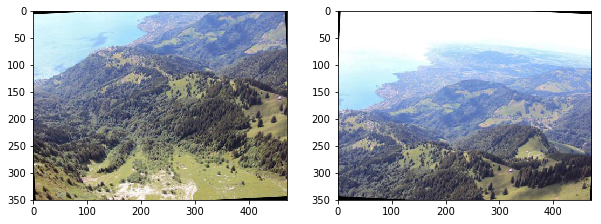

In [127]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)

In [128]:
#Detect keypoints
blobs1 = detectBlobs(im1, {'level': 9, 'cutoff': 5e-2})
blobs2 = detectBlobs(im2, {'level': 9, 'cutoff': 5e-2})

#Compute SIFT features
sift1 = compute_sift(im1, blobs1)
sift2 = compute_sift(im2, blobs2)

Convolving with sigma=1.2
Convolving with sigma=1.6099689438
Convolving with sigma=2.16
Convolving with sigma=2.89794409884
Convolving with sigma=3.888
Convolving with sigma=5.21629937791
Convolving with sigma=6.9984
Convolving with sigma=9.38933888024
Convolving with sigma=12.59712
Convolving with sigma=16.9008099844
Convolving with sigma=22.674816
Convolving with sigma=30.421457972
Convolving with sigma=40.8146688
Iterating for Level=0
Iterating for Level=1
Iterating for Level=2
Iterating for Level=3
Iterating for Level=4
Iterating for Level=5
Iterating for Level=6
Iterating for Level=7
Iterating for Level=8
Iterating for Level=9
Iterating for Level=10
Iterating for Level=11
Iterating for Level=12
Convolving with sigma=1.2
Convolving with sigma=1.6099689438
Convolving with sigma=2.16
Convolving with sigma=2.89794409884
Convolving with sigma=3.888
Convolving with sigma=5.21629937791
Convolving with sigma=6.9984
Convolving with sigma=9.38933888024
Convolving with sigma=12.59712
Convolv

In [129]:
len(sift1), len(sift2)

(4042, 3249)

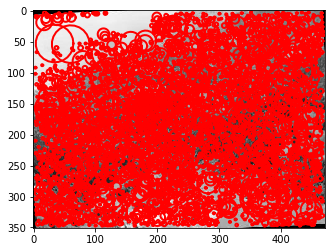

In [130]:
drawBlobs(im1, blobs1)

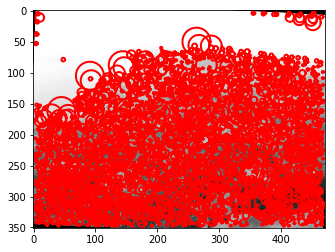

In [131]:
drawBlobs(im2, blobs2)

In [172]:
def add_extra_dim(matching_blobs):
    return np.hstack([matching_blobs, np.ones((matching_blobs.shape[0], 1))])

def ransac12(matches, blobs1, blobs2, param={}):
    default_max_itr, default_reject_limit = 500, 100
    max_iteration = param.get("max_iteration") if param.get("max_iteration") is not None else default_max_itr
    reject_limit = param.get("reject_limit") if param.get("reject_limit") is not None else default_reject_limit
    pairs = max(int(matches.shape[0] * 0.01), 3)
    constant_padding = np.array([0, 0, 1])
    blob1_matches = add_extra_dim(blobs2[:, [0, 1]][matches])
    blob2_matches = add_extra_dim(blobs1[:, [0, 1]][matches])
    total_inliers, best_inlier_model = 0, np.zeros(matches.shape[0])
    for i_ in range(max_iteration):
        idxs = np.random.choice(matches.shape[0], pairs, replace=False)
        selected1 = blob1_matches[idxs, :]
        selected2 = blob2_matches[idxs, :]
        transf, _, _, _ = np.linalg.lstsq(selected2, selected1, rcond=None)
        curr_inliers = np.linalg.norm(np.dot(blob2_matches, transf) - blob1_matches, axis=1) **2 < reject_limit
        if np.sum(curr_inliers) > total_inliers:
            total_inliers = np.sum(curr_inliers)
            best_inlier_model = np.copy(curr_inliers)
            print(total_inliers)
    transf, _, _, _ = np.linalg.lstsq(blob2_matches[best_inlier_model], blob1_matches[best_inlier_model], rcond=None)
    return best_inlier_model, transf[:2, :3]

from scipy.spatial.distance import cdist
def computeMatches12(f1, f2):
    """ Match two sets of SIFT features f1 and f2 """
    reject_limit = .50 #.95
    matches = []
    distance_matrix = cdist(f1, f2)
    
    smallest = f1
    if (f1.shape[0] > f2.shape[0]):
        smallest = f2
    for n in range(smallest.shape[0]):
        currd_matrix = distance_matrix[n]
        if (np.min(currd_matrix) / np.partition(currd_matrix, 2)[1]) < reject_limit:
            matches.append([n])
    matches = np.squeeze(np.array(matches))
    return matches

594


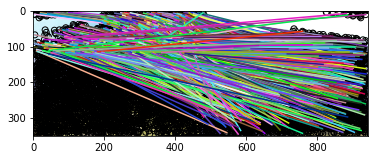

In [157]:
# #Find the matching between features
matches = computeMatches12(sift1, sift2)
print (len(matches))
showMatches(im1, im2, blobs1, blobs2, matches)

1
2
7
9
14
15
21


Text(0.5,1,'stitched image: ledge')

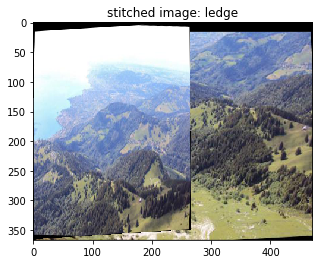

In [179]:
inliers, transf = ransac12(matches, blobs1, blobs2)

goodMatches = np.zeros_like(matches)
goodMatches[inliers] = matches[inliers]

#Merge two images and display the output

stitchIm = mergeImages(im1, im2, transf)
plt.figure()
plt.imshow(stitchIm)
plt.title('stitched image: {}'.format(testExamples[exampleIndex]))

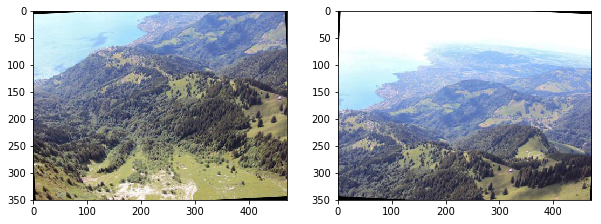

In [171]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)